In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [10]:
import nltk

In [11]:
import string
from nltk.corpus import stopwords

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
from sklearn.feature_extraction.text import TfidfTransformer

In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [3]:
dataframe = pd.read_csv("bbc-text.csv")
dataframe.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [4]:
dataframe["category"].unique()

dataframe.describe()

,category,text
count,2225,2225
unique,5,2126
top,sport,kennedy questions trust of blair lib dem leade...
freq,511,2


In [5]:
dataframe.groupby("category").describe()

text                                                            \
              count unique                                                top   
category                                                                        
business        510    503  economy  strong  in election year uk businesse...   
entertainment   386    369  ocean s twelve raids box office ocean s twelve...   
politics        417    403  super union  merger plan touted two of britain...   
sport           511    504  hantuchova in dubai last eight daniela hantuch...   
tech            401    347  california sets fines for spyware the makers o...   

                    
              freq  
category            
business         2  
entertainment    2  
politics         2  
sport            2  
tech             2

In [6]:
dataframe["text_length"] = dataframe["text"].apply(len)
dataframe.head()

,category,text,text_length
0,tech,tv future in the hands of viewers with home th...,4333
1,business,worldcom boss left books alone former worldc...,1842
2,sport,tigers wary of farrell gamble leicester say ...,1342
3,sport,yeading face newcastle in fa cup premiership s...,2176
4,entertainment,ocean s twelve raids box office ocean s twelve...,1579


In [7]:
dataframe["text_length"]

0       4333
1       1842
2       1342
3       2176
4       1579
        ... 
2220    1745
2221     955
2222    1648
2223    4684
2224    1167
Name: text_length, Length: 2225, dtype: int64

In [8]:
dataframe["text_length"].describe()

count     2225.00000
mean      2262.93618
std       1364.10253
min        501.00000
25%       1446.00000
50%       1965.00000
75%       2802.00000
max      25483.00000
Name: text_length, dtype: float64

<Figure size 432x288 with 0 Axes>

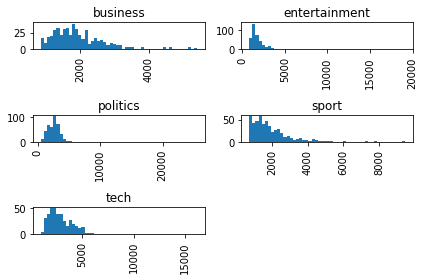

In [9]:
plt.figure()
dataframe.hist(column = "text_length",by = "category",bins = 50)
plt.tight_layout()

In [12]:
def text_preprocess(text):
    rem_punctuation = [word for word in text if word not in string.punctuation]
    new_mess = "".join(rem_punctuation)
    return [word for word in new_mess.split() if word.lower() not in stopwords.words("english") ]

In [13]:
dataframe["text"].head().apply(text_preprocess)

0    [tv, future, hands, viewers, home, theatre, sy...
1    [worldcom, boss, left, books, alone, former, w...
2    [tigers, wary, farrell, gamble, leicester, say...
3    [yeading, face, newcastle, fa, cup, premiershi...
4    [ocean, twelve, raids, box, office, ocean, twe...
Name: text, dtype: object

In [17]:
bag_of_words = CountVectorizer(analyzer=text_preprocess).fit(dataframe["text"])
text_summary = bag_of_words.transform(dataframe["text"])

In [18]:
print('Shape of Sparse Matrix: ', text_summary.shape)
print('Amount of Non-Zero occurences: ', text_summary.nnz)

Shape of Sparse Matrix:  (2225, 32955)
Amount of Non-Zero occurences:  351196


In [19]:
sparsity = (100*text_summary.nnz/(text_summary.shape[0]*text_summary.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


In [20]:
tfidf_transformer = TfidfTransformer().fit(text_summary)

In [21]:
print(bag_of_words.get_feature_names()[4073])
print(bag_of_words.get_feature_names()[9570])

backdoor
discriminate


In [24]:
text_tfidf = tfidf_transformer.transform(text_summary)
print(text_tfidf.shape)

(2225, 32955)


In [25]:
news_detect_model = MultinomialNB().fit(text_tfidf, dataframe["category"])

In [26]:
txt_train, txt_test, category_train, category_test = train_test_split(dataframe["text"], dataframe["category"], test_size=0.2)

print(len(txt_train), len(txt_test), len(txt_train) + len(txt_test))

1780 445 2225


In [27]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_preprocess)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [28]:
pipeline.fit(txt_train,category_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_preprocess at 0x000001F68516EEE0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [29]:
predictions = pipeline.predict(txt_test)

In [30]:
print(classification_report(predictions,category_test))

               precision    recall  f1-score   support

     business       0.97      0.96      0.97       101
entertainment       0.95      0.98      0.97        63
     politics       0.97      0.97      0.97        93
        sport       1.00      1.00      1.00        97
         tech       0.98      0.97      0.97        91

     accuracy                           0.98       445
    macro avg       0.97      0.98      0.97       445
 weighted avg       0.98      0.98      0.98       445

